## Appstore Games EDA & ML

#### Data: 17,007 strategy games on the Apple App Store
#### Aims: To identify features that can potentitally predict a game's popularity, and compare selected ML models.
#### Part 1: Prepare and clean data

In [1]:
# Import libraries

import re
import math
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn import metrics
from sklearn import tree

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold 
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

In [2]:
# Load and read data

games = pd.read_csv('appstore_games.csv')
games.head()

,URL,ID,Name,Subtitle,Icon URL,Average User Rating,User Rating Count,Price,In-app Purchases,Description,Developer,Age Rating,Languages,Size,Primary Genre,Genres,Original Release Date,Current Version Release Date
0,https://apps.apple.com/us/app/sudoku/id284921427,284921427,Sudoku,NaN,https://is2-ssl.mzstatic.com/image/thumb/Purpl...,4.0,3553.0,2.99,NaN,"Join over 21,000,000 of our fans and download ...",Mighty Mighty Good Games,4+,"DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...",15853568.0,Games,"Games, Strategy, Puzzle",11/07/2008,30/05/2017
1,https://apps.apple.com/us/app/reversi/id284926400,284926400,Reversi,NaN,https://is4-ssl.mzstatic.com/image/thumb/Purpl...,3.5,284.0,1.99,NaN,"The classic game of Reversi, also known as Oth...",Kiss The Machine,4+,EN,12328960.0,Games,"Games, Strategy, Board",11/07/2008,17/05/2018
2,https://apps.apple.com/us/app/morocco/id284946595,284946595,Morocco,NaN,https://is5-ssl.mzstatic.com/image/thumb/Purpl...,3.0,8376.0,0.00,NaN,Play the classic strategy game Othello (also k...,Bayou Games,4+,EN,674816.0,Games,"Games, Board, Strategy",11/07/2008,5/09/2017
3,https://apps.apple.com/us/app/sudoku-free/id28...,285755462,Sudoku (Free),NaN,https://is3-ssl.mzstatic.com/image/thumb/Purpl...,3.5,190394.0,0.00,NaN,"Top 100 free app for over a year.\nRated ""Best...",Mighty Mighty Good Games,4+,"DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...",21552128.0,Games,"Games, Strategy, Puzzle",23/07/2008,30/05/2017
4,https://apps.apple.com/us/app/senet-deluxe/id2...,285831220,Senet Deluxe,NaN,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,3.5,28.0,2.99,NaN,"""Senet Deluxe - The Ancient Game of Life and A...",RoGame Software,4+,"DA, NL, EN, FR, DE, EL, IT, JA, KO, NO, PT, RU...",34689024.0,Games,"Games, Strategy, Board, Education",18/07/2008,22/07/2018


In [3]:
# Check datatypes

games.dtypes

URL                              object
ID                                int64
Name                             object
Subtitle                         object
Icon URL                         object
Average User Rating             float64
User Rating Count               float64
Price                           float64
In-app Purchases                 object
Description                      object
Developer                        object
Age Rating                       object
Languages                        object
Size                            float64
Primary Genre                    object
Genres                           object
Original Release Date            object
Current Version Release Date     object
dtype: object

In [4]:
# Overview of dataset

print('Number of rows:', games.shape[0])
print('Number of columns:', games.shape[1])
print('Overview:', games.info())

Number of rows: 17007
Number of columns: 18
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17007 entries, 0 to 17006
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   URL                           17007 non-null  object 
 1   ID                            17007 non-null  int64  
 2   Name                          17007 non-null  object 
 3   Subtitle                      5261 non-null   object 
 4   Icon URL                      17007 non-null  object 
 5   Average User Rating           7561 non-null   float64
 6   User Rating Count             7561 non-null   float64
 7   Price                         16983 non-null  float64
 8   In-app Purchases              7683 non-null   object 
 9   Description                   17007 non-null  object 
 10  Developer                     17007 non-null  object 
 11  Age Rating                    17007 non-null  object 
 12  Languages       

In [5]:
# Remove columns not suitable for ML

games = games.drop(['ID','URL','Subtitle','Icon URL','Description'], axis = 1)

In [6]:
# Summary of NA values

total = games.isnull().sum().sort_values(ascending=False)
percent = (total/games.isnull().count()).sort_values(ascending=False)*100
dtype = games.dtypes
na_table = pd.concat([total,percent,dtype], axis=1, keys=['Total', '%', 'Dtype'])
na_table

,Total,%,Dtype
Average User Rating,9446,55.541836,float64
User Rating Count,9446,55.541836,float64
In-app Purchases,9324,54.824484,object
Languages,60,0.352796,object
Price,24,0.141118,float64
Size,1,0.005880,float64
Name,0,0.000000,object
Developer,0,0.000000,object
Age Rating,0,0.000000,object
Primary Genre,0,0.000000,object


In [7]:
# Clean Data/Replace null values

# Replace NA values with median. 
# Languages: Replace NA values with EN.
# In-app Purchases: Replace NA values with 0. Assume game did not offer in-app purchases.
# Convert In-app Purchases to 1 (offer) and 0 (not offered)

games['Average User Rating'] = games['Average User Rating'].fillna(games['Average User Rating'].median())
games['User Rating Count'] = games['User Rating Count'].fillna(games['User Rating Count'].median())
games['Price'] = games['Price'].fillna(games['Price'].median())
games['Size'] = games['Size'].fillna(games['Size'].median())
games['Languages'] = games['Languages'].fillna("EN", axis=0)
games['In-app Purchases'] = games['In-app Purchases'].fillna(0, axis=0)

In [8]:
# Create function to obtain mean of 'In-app Purchases'

def getmean(text): #gets the mean of a string with a list of floats. if text = 0 returns 0
    if text == 0:
        return 0
    numlist = [float(s) for s in re.findall(r'-?\d+\.?\d*', text)]
    meanlist = np.mean(numlist)
    return meanlist

games['In-app Purchases'] = games['In-app Purchases'].apply(getmean)
games.sample(5)

,Name,Average User Rating,User Rating Count,Price,In-app Purchases,Developer,Age Rating,Languages,Size,Primary Genre,Genres,Original Release Date,Current Version Release Date
7465,"Roller Block: Think, Roll, Win",4.5,10.0,0.0,0.00,The FastMind,4+,EN,176918528.0,Games,"Games, Strategy, Puzzle",22/12/2015,25/09/2016
4309,DoDots: Capture the Rival,4.5,6.0,0.0,4.49,YENA Software GmbH,4+,EN,23793664.0,Games,"Games, Puzzle, Strategy",9/01/2015,20/05/2015
12973,Badger Dojo -Train For Victory,4.5,46.0,0.0,0.99,BrotherSoft,4+,EN,82276352.0,Games,"Games, Puzzle, Education, Strategy",15/02/2018,31/07/2019
10750,Star Warships: Galaxy Crowns,2.0,81.0,0.0,16.49,"REALITY SQUARED GAME CO., LIMITED",9+,EN,122253312.0,Games,"Games, Simulation, Strategy",25/01/2017,22/08/2018
6189,My Business Empire,4.0,262.0,0.0,1.99,Brandon Stecklein,4+,EN,131091456.0,Games,"Games, Strategy, Simulation",2/06/2015,9/07/2019


In [9]:
# Review null replacements

total = games.isnull().sum().sort_values(ascending=False)
percent = (total/games.isnull().count()).sort_values(ascending=False)*100
dtype = games.dtypes
na_table = pd.concat([total,percent,dtype], axis=1, keys=['Total', '%', 'Dtype'])
na_table.head()

,Total,%,Dtype
Name,0,0.0,object
Average User Rating,0,0.0,float64
User Rating Count,0,0.0,float64
Price,0,0.0,float64
In-app Purchases,0,0.0,float64


In [10]:
# Convert size to MB
# Convert Original Release Date + Current Version Release Date to year XXXX
# Simplify Age Rating values to integers
# Count number of languages for each game

games['Size'] = round(games['Size']/(10**6), 2)
games['Original Release Year'] = pd.DatetimeIndex(games['Original Release Date']).year
games['Current Ver. Release Year'] = pd.DatetimeIndex(games['Current Version Release Date']).year
games = games.drop(['Original Release Date', 'Current Version Release Date'], axis = 1)
games['Age Rating'] = games['Age Rating'].str.replace('+','',regex=True).astype(int)
games['Languages'] = games['Languages'].apply(lambda x: len(x.split(',')))
games.sample(3)

,Name,Average User Rating,User Rating Count,Price,In-app Purchases,Developer,Age Rating,Languages,Size,Primary Genre,Genres,Original Release Year,Current Ver. Release Year
16383,Curvy Path Maths 3d Game 2019,4.5,46.0,0.00,5.99,Khushal Khan,4,1,75.74,Games,"Games, Entertainment, Word, Strategy",2019,2019
14803,Defense Legend 3: Furure War,4.0,58.0,0.00,10.19,Do Anh Tu,9,1,347.98,Games,"Games, Entertainment, Strategy, Action",2018,2019
10282,Square Dash: Jump the Line Pro,4.5,46.0,2.99,0.00,"Netsummit Marketing, Inc.",4,1,10.56,Games,"Games, Family, Strategy",2016,2016


In [11]:
# Transform 'Primary Genre' + 'Genres'
# Designate 'Secondary Genre' as 'Genre'

games = games.drop(['Primary Genre'], axis = 1)

Primary_Genre = []
Secondary_Genre = []
for x in games['Genres']:
    Primary_Genre.append(x.split(',')[0])
    Secondary_Genre.append(x.split(',')[1])
    
games['Primary Genre'] = Primary_Genre
games['Genres'] = Secondary_Genre

games.rename(columns={"Genres": "Secondary Genre"}, inplace = True)
games = games.drop(['Primary Genre'], axis = 1)
games.rename(columns = {'Secondary Genre': 'Genre'}, inplace = True)
games.sample(5)

,Name,Average User Rating,User Rating Count,Price,In-app Purchases,Developer,Age Rating,Languages,Size,Genre,Original Release Year,Current Ver. Release Year
1204,Battle Minesweeper:Ai,4.0,13.0,0.0,0.99,CiRE software,4,3,40.82,Family,2012,2012
14320,Duty of Army Frontline 3D,4.5,46.0,0.0,0.00,Vu Hoang Anh,17,1,181.76,Adventure,2018,2018
1524,Diamond Gems,4.5,2933.0,0.0,0.00,Balloon Island,4,1,27.33,Board,2012,2018
9955,Jewel Candy Match Puzzle,4.5,46.0,0.0,0.00,Vikash Patel,4,1,5.67,Entertainment,2016,2016
14628,XGap.io,4.5,46.0,0.0,0.00,"Appulet, Inc",4,2,28.21,Family,2018,2018


In [12]:
# Calculate Total Score with Avg. User Rating + User Rating Count

games_score = games['Average User Rating'] * games['User Rating Count']
games['Total Score'] = games_score

games_time = 2020 - games['Original Release Year']
games['Years Running'] = games_time

games = games.drop(['Original Release Year', 'Current Ver. Release Year'], axis = 1)

games.sample(5)

,Name,Average User Rating,User Rating Count,Price,In-app Purchases,Developer,Age Rating,Languages,Size,Genre,Total Score,Years Running
6598,Crocodile River - Jungle Attack Crossing,4.5,46.0,0.0,0.00,Superpea LTD.,9,1,79.86,Strategy,207.0,5
2211,Happy Chef 2,4.5,16409.0,0.0,2.74,Nordcurrent,4,6,185.33,Strategy,73840.5,7
11533,"Port Tycoon: Ship, Truck & Manual Crane Simulator",4.5,46.0,0.0,0.00,Tayga Games OOO,4,1,112.29,Strategy,207.0,3
7630,Tartan Tiles,4.5,46.0,0.0,1.49,Smogz Media,4,1,248.30,Strategy,207.0,4
14112,Battle Simulator 2,4.0,25.0,0.0,9.99,Playstarz Inc.,4,1,163.33,Simulation,100.0,2


#### Part 2: EDA

In [13]:
# Explore correlations between numerical variables

games_num = games[['Total Score', 'User Rating Count', 'Years Running', 'Price', 'In-app Purchases', 'Size', 'Age Rating', 'Languages']]
games_num.corr()

,Total Score,User Rating Count,Years Running,Price,In-app Purchases,Size,Age Rating,Languages
Total Score,1.000000,0.998843,0.036415,-0.003778,0.066789,0.040908,0.032340,0.060667
User Rating Count,0.998843,1.000000,0.041237,-0.003868,0.067014,0.040466,0.032373,0.061018
Years Running,0.036415,0.041237,1.000000,0.006852,-0.035802,-0.175387,-0.078175,0.037465
Price,-0.003778,-0.003868,0.006852,1.000000,-0.033031,0.033067,0.032501,-0.019240
In-app Purchases,0.066789,0.067014,-0.035802,-0.033031,1.000000,0.228585,0.231269,0.158598
Size,0.040908,0.040466,-0.175387,0.033067,0.228585,1.000000,0.265087,0.035239
Age Rating,0.032340,0.032373,-0.078175,0.032501,0.231269,0.265087,1.000000,0.049103
Languages,0.060667,0.061018,0.037465,-0.019240,0.158598,0.035239,0.049103,1.000000


In [14]:
# Filter array

mask = np.zeros_like(games_num.corr())
triangle_indices = np.triu_indices_from(mask)
mask[triangle_indices] = True
mask

array([[1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

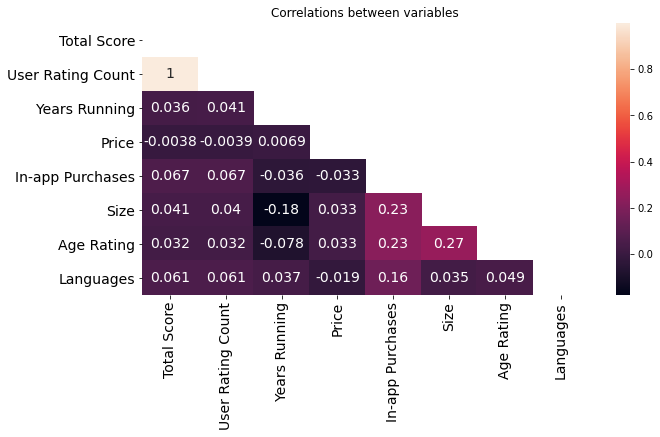

In [15]:
# Plot heatmap for visualisation

plt.figure(figsize = (10,5))
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
sns.heatmap(games_num.corr(), mask = mask, annot = True, annot_kws = {'size': 14}) 
plt.title('Correlations between variables')
plt.show()

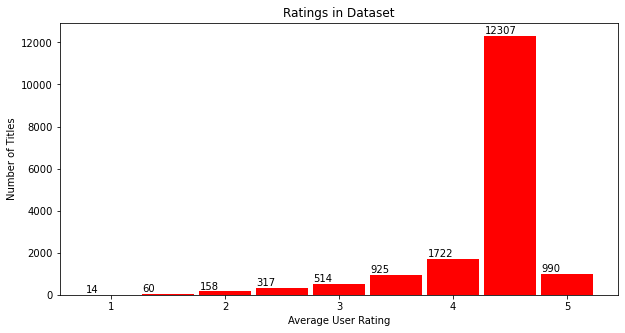

In [16]:
# Proportion of User Ratings

a = []
b = []
for x,y in games['Average User Rating'].value_counts().iteritems():
    a.append(x)
    b.append(y)
    
plt.figure(figsize = (10, 5))
bars = plt.bar(a, b, color = 'red', width =0.45, align = 'center')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + 100, yval, ma = 'center') 
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.title('Ratings in Dataset')
plt.xlabel('Average User Rating')
plt.ylabel('Number of Titles')
plt.show()

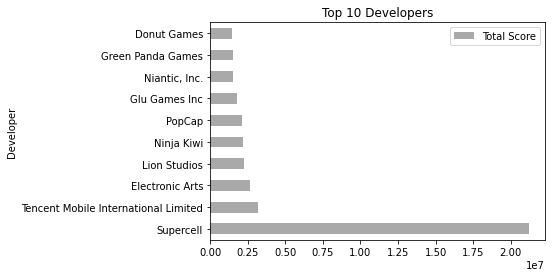

In [17]:
# Top developers based on total scores

games_dev = pd.pivot_table(games, index = 'Developer', values = ['Total Score'], aggfunc = np.sum).sort_values(by=['Total Score'], ascending=False)
games_dev_top = games_dev.head(10)

games_dev_top.plot(y = 'Total Score', kind ='barh', color ='darkgrey')
plt.title('Top 10 Developers')
plt.show()

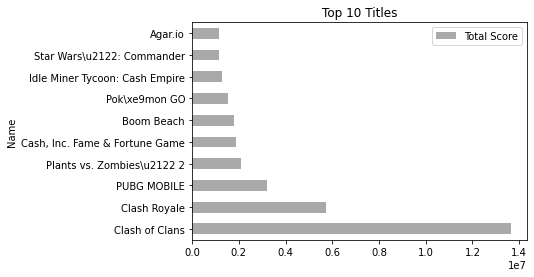

In [18]:
# Top titles based on total scores

games_title = pd.pivot_table(games, index = 'Name', values = ['Total Score'], aggfunc = np.sum).sort_values(by=['Total Score'], ascending=False)
games_title_top = games_title.head(10)

games_title_top.plot(y = 'Total Score', kind ='barh', color ='darkgrey')
plt.title('Top 10 Titles')
plt.show()

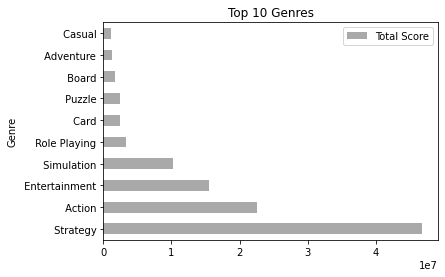

In [19]:
# Top genres based on total scores

games_genre = pd.pivot_table(games, index = 'Genre', values = ['Total Score'], aggfunc=np.sum).sort_values(by=['Total Score'], ascending=False)
games_genre_top = games_genre.head(10)

games_genre_top.plot(y = 'Total Score', kind ='barh', color ='darkgrey')
plt.title('Top 10 Genres')
plt.show()

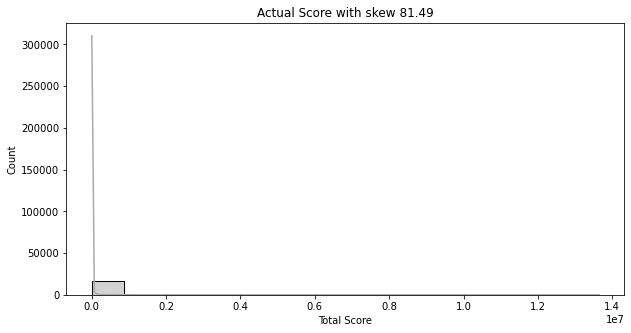

In [20]:
# Check skew

games_skew_check = games['Total Score'].skew()

plt.figure(figsize = (10, 5))
sns.histplot(games['Total Score'], color = 'darkgrey', kde = True)
plt.title(f'Actual Score with skew {round(games_skew_check,2)}') 
plt.show()

In [21]:
# Select top 5% of games for ML analysis

games_top = games.sort_values(by=['Total Score'], ascending=False)
games_top = games_top.head(850)
games_top.head(10)

,Name,Average User Rating,User Rating Count,Price,In-app Purchases,Developer,Age Rating,Languages,Size,Genre,Total Score,Years Running
1378,Clash of Clans,4.5,3032734.0,0.0,19.990000,Supercell,9,20,161.22,Action,13647303.0,8
7187,Clash Royale,4.5,1277095.0,0.0,7.790000,Supercell,9,15,145.11,Strategy,5746927.5,4
13414,PUBG MOBILE,4.5,711409.0,0.0,18.240000,Tencent Mobile International Limited,17,12,2384.08,Action,3201340.5,2
1921,Plants vs. Zombies\u2122 2,4.5,469562.0,0.0,4.990000,PopCap,9,6,120.76,Strategy,2113029.0,7
12473,"Cash, Inc. Fame & Fortune Game",5.0,374772.0,0.0,10.990000,Lion Studios,4,1,245.96,Strategy,1873860.0,3
2410,Boom Beach,4.5,400787.0,0.0,24.865000,Supercell,9,18,202.79,Strategy,1803541.5,6
8139,Pok\xe9mon GO,3.5,439776.0,0.0,29.323333,"Niantic, Inc.",9,9,281.52,Strategy,1539216.0,4
8632,Idle Miner Tycoon: Cash Empire,4.5,283035.0,0.0,8.390000,Kolibri Games GmbH,4,28,443.97,Simulation,1273657.5,4
3550,Star Wars\u2122: Commander,4.5,259030.0,0.0,25.290000,NaturalMotion,9,11,123.08,Entertainment,1165635.0,6
6144,Agar.io,4.5,257852.0,0.0,4.090000,Miniclip.com,9,9,83.95,Strategy,1160334.0,5


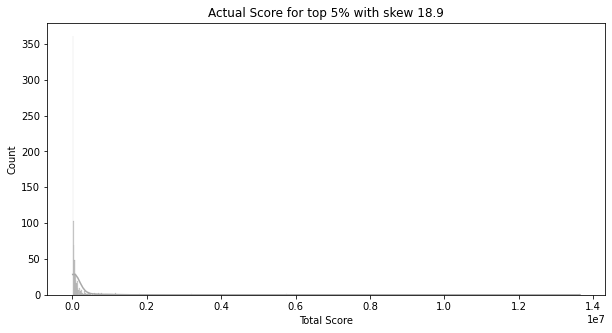

In [22]:
# Check and visualise skew

games_top_skew = games_top['Total Score'].skew()

plt.figure(figsize = (10, 5))
sns.histplot(games_top['Total Score'], color = 'darkgrey', kde = True)
plt.title(f'Actual Score for top 5% with skew {round(games_top_skew,2)}') 
plt.show()

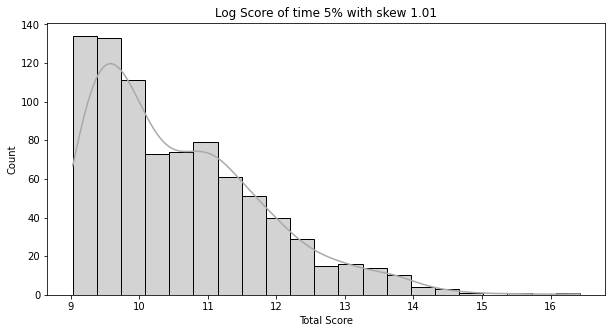

In [23]:
# Check and visualise skew for log values

games_top_log = np.log(games_top['Total Score'])
games_top_skew = games_top_log.skew()

plt.figure(figsize = (10, 5))
sns.histplot(games_top_log, color = 'darkgrey', kde = True)
plt.title(f'Log Score of time 5% with skew {round(games_top_skew,2)}') 
plt.show()

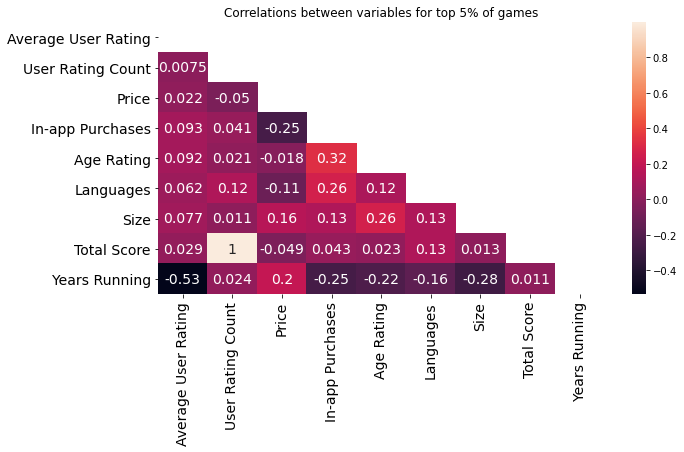

In [24]:
# Filter array & visualise correlations

mask = np.zeros_like(games_top.corr())
triangle_indices = np.triu_indices_from(mask)
mask[triangle_indices] = True

plt.figure(figsize = (10,5))
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
sns.heatmap(games_top.corr(), mask = mask, annot = True, annot_kws = {'size': 14}) 
plt.title('Correlations between variables for top 5% of games')
plt.show()


#### Part 3: Linear Regression

In [25]:
# Set features and target

features = games_num.drop(['Total Score'], axis = 1)
target = games_num['Total Score']

# Scale Data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [26]:
# Fit and train model
# Use statsmodel to compute regression

x_train, x_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state= 42)

x_const = sm.add_constant(x_train)
model = sm.OLS(y_train, x_const)
results = model.fit()

results.summary(xname = ['Intercept', 'User Rating Count', 'Years Running', 'Price', 'In-app Purchases', 'Size', 'Age Rating', 'Languages'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Total Score   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 9.346e+05
Date:                Thu, 16 Jun 2022   Prob (F-statistic):               0.00
Time:                        22:38:18   Log-Likelihood:            -1.3803e+05
No. Observations:               13605   AIC:                         2.761e+05
Df Residuals:                   13597   BIC:                         2.761e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          6570.5609     52.865    124.290      0.000    6466.938    6674.183
User Rating Count  1.265e+05     49.661   2547.831      0.000    1.26e+05    1.27e+05
Years Running      -562.9649     53.876    -10.449      0.000    -668.569    -457.361
Price                16.3007     57.501      0.283      0.777     -96.410     129.011
In-app Purchases    -39.5731     55.813     -0.709      0.478    -148.975      69.829
Size                -21.0366     57.258     -0.367      0.713    -133.271      91.197
Age Rating          -74.5077     55.729     -1.337      0.181    -183.744      34.728
Languages            -5.2218     53.060     -0.098      0.922    -109.227      98.783
==============================================================================
Omnibus:                    37252.579   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       2876670526.399
Skew:                         -33.905   Prob(JB):                         0.00
Kurtosis:                    2254.669   Cond. No.                         1.51
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
# Check for multicollinearity

vif = []
for i in range(x_const.shape[1]):
    vif.append(variance_inflation_factor(exog = x_const, exog_idx = i))

pd.DataFrame({'Variance Inflation Factor': np.around(vif,3)})

,Variance Inflation Factor
0,1.000
1,1.008
2,1.038
3,1.004
4,1.122
5,1.148
6,1.120
7,1.031


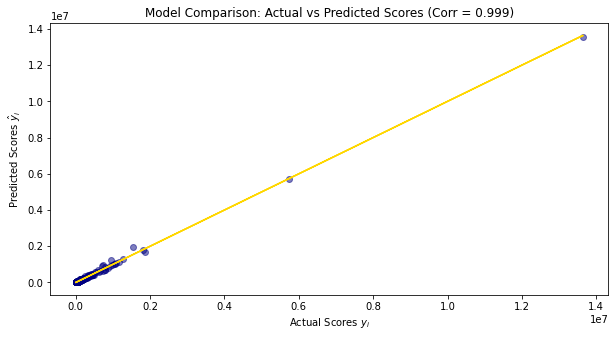

In [28]:
# Plot actual vs predicted total scores
# Line indicates assumed perfect fit (residuals = 0)

corr = round(y_train.corr(results.fittedvalues),3)

plt.figure(figsize = (10, 5))
plt.scatter(x = y_train, y = results.fittedvalues, color = 'Navy', alpha = 0.5)
plt.plot(y_train, y_train, color = 'Gold')
plt.title(f'Model Comparison: Actual vs Predicted Scores (Corr = {corr})')
plt.xlabel('Actual Scores $y_i$')
plt.ylabel('Predicted Scores $\hat y_i$')
plt.show()

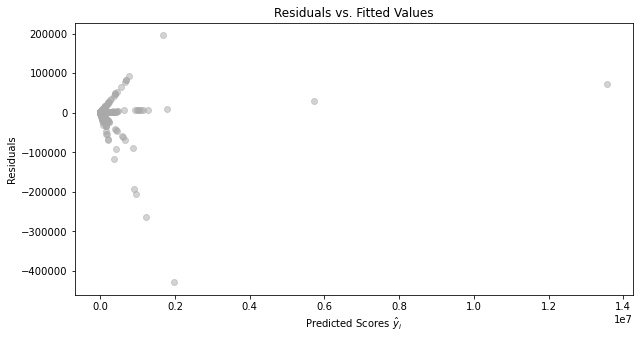

In [29]:
# Plot Residuals

plt.figure(figsize = (10, 5))
plt.scatter(x = results.fittedvalues, y = results.resid, color = 'DarkGray', alpha = 0.5)
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Predicted Scores $\hat y_i$')
plt.ylabel('Residuals')
plt.show()

In [30]:
# Cross Validation

# Set up 5-fold cross validation  

X = games_num.drop('Total Score', axis = 1)
Y = games_num['Total Score']

k_fold = KFold(5, shuffle=True)
train_scores = []
train_rmse = []
test_scores = []
test_rmse = []

for k, (train, test) in enumerate(k_fold.split(X)):
    
    # Get training and test sets for X and y
    X_train = X.iloc[train, ]
    Y_train = Y.iloc[train, ]
    X_test = X.iloc[test, ]
    Y_test = Y.iloc[test, ]

    # Fit model with training set
    model = LinearRegression()
    model.fit(X_train, Y_train)
    
    # Make predictions with training and test set
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    # Score R2 and RMSE on training and test sets and store in list
    train_scores.append(model.score(X_train, Y_train))
    test_scores.append(model.score(X_test, Y_test))
    train_rmse.append(math.sqrt(metrics.mean_squared_error(Y_train, y_pred_train)))
    test_rmse.append(math.sqrt(metrics.mean_squared_error(Y_test, y_pred_test)))

# Create a metrics_df dataframe to display r2 and rmse scores

df_scores = pd.DataFrame({'Train Scores': train_scores, 'Train RMSE': train_rmse, 'Test Scores': test_scores, 'Test RMSE': test_rmse})
df_scores

,Train Scores,Train RMSE,Test Scores,Test RMSE
0,0.993235,6352.022344,0.999394,5832.928152
1,0.998871,4603.912401,0.979733,10018.521115
2,0.997568,6472.909002,0.998589,3963.962079
3,0.997761,6562.995285,0.996414,3315.887859
4,0.998122,5946.679877,0.991106,6466.916244


#### Part 4: Logistic Regression

In [31]:
# Create dummy variables

games_with_dummies = pd.get_dummies(data = games_top, columns = ['Developer', 'Genre'], 
                                      prefix = ['Developer', 'Genre'] )
games_with_dummies.sample(3)

,Name,Average User Rating,User Rating Count,Price,In-app Purchases,Age Rating,Languages,Size,Total Score,Years Running,...,Genre_ Lifestyle,Genre_ Music,Genre_ Puzzle,Genre_ Racing,Genre_ Role Playing,Genre_ Simulation,Genre_ Social Networking,Genre_ Sports,Genre_ Strategy,Genre_ Word
2357,Hunter Island: Monsters & Dragons,4.5,5409.0,0.99,31.990000,9,6,91.31,24340.5,7,...,0,0,0,0,0,0,0,0,1,0
797,Finger Shot RPG,5.0,2966.0,0.99,6.418571,4,2,61.28,14830.0,9,...,0,0,0,0,0,0,0,0,1,0
5331,Dragon Blaze,4.5,2842.0,0.00,28.090000,12,10,140.38,12789.0,5,...,0,0,0,0,1,0,0,0,0,0


In [32]:
# Create and Fit Model

X = games_with_dummies.drop(['Total Score', 'Name', 'Average User Rating'], axis = 1)
Y = games_with_dummies['Total Score'].apply(lambda x:1 if x >= games_top['Total Score'].mean() else 0)

# Scale data

scaler = MinMaxScaler()
Xs = scaler.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(Xs, Y, test_size = 0.20, random_state = 42)

Y.value_counts(normalize = True)

0    0.825882
1    0.174118
Name: Total Score, dtype: float64

In [33]:
logreg = LogisticRegression(max_iter = 10000)
logreg.fit(X_train,Y_train)

# Cross Validation

scores = cross_val_score(logreg, X_train, Y_train, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.83 accuracy with a standard deviation of 0.01


In [34]:
# Custom Function for summary report

def summary_report(actual, prediction, probabilities):
    if isinstance(actual, pd.Series):
       actual = actual.values.astype(int)
    prediction = prediction.astype(int)
    #--- Accuracy score ---
    print('Accuracy : %.4f [TP / N] Proportion of Predicted Labels that match the True Labels.Best: 1, Worst: 0' % metrics.accuracy_score(actual, prediction))
    #--- Precision score ---
    print('Precision: %.4f [TP / (TP + FP)] Not to Label a negative sample as positive. Best:1, Worst: 0' % metrics.precision_score(actual, prediction))
    #--- Recall score ---
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples. Best:1, Worst: 0' % metrics.recall_score(actual, prediction))
    #--- ROC AUC ---
    print('ROC AUC  : %.4f Best:1, Worst: < 0.5' % metrics.roc_auc_score(actual, probabilities[:, 1]))
    print('='* 100)
    print('TP: True Positives, FP: False Positives,')
    print('TN: True Negatives, FN: False Negatives,')
    print('N: Number of Samples')
    # Confusion Matrix
    CM = metrics.confusion_matrix(actual, prediction)
    # Precision/Recall
    precision, recall, _ = metrics.precision_recall_curve(actual, prediction)
    average_precision = metrics.average_precision_score(actual, prediction)
    # Compute ROC Curve and ROC area
    fpr, tpr, _ = metrics.roc_curve(actual, probabilities[:, 1])
    roc_auc = metrics.auc(fpr, tpr)
    #--- Plot Graph ---
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    fig.subplots_adjust(left=0.02, right=0.98, wspace=0.2)
    # Confusion Matrix
    sns.heatmap(CM.T, square=True, annot=True, fmt='d', cbar=False, ax=ax[0], xticklabels =['Not Popular', 'Popular'], yticklabels = ['Not Popular', 'Popular'])
    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('True Label')
    ax[0].set_ylabel('Predicted Label')
    # Precision-recall curve
    step_kwargs = {'step': 'post'}
    ax[1].step(recall, precision, color='b', alpha=0.2, where='post')
    ax[1].fill_between(recall, precision, color='b', alpha=0.2, **step_kwargs)
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('2-Class Precision-Recall Curve')
    # ROC
    ax[2].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC - %0.4f)' % roc_auc)
    ax[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].set_xlabel('False Positive Rate')
    ax[2].set_ylabel('True Positive Rate')
    ax[2].set_title('Receiver Operating Characteristic - ROC')
    ax[2].legend(loc='lower right')
    plt.show()

Accuracy : 0.8324 [TP / N] Proportion of Predicted Labels that match the True Labels.Best: 1, Worst: 0
Precision: 1.0000 [TP / (TP + FP)] Not to Label a negative sample as positive. Best:1, Worst: 0
Recall   : 0.0256 [TP / (TP + FN)] Find all the positive samples. Best:1, Worst: 0
ROC AUC  : 0.9643 Best:1, Worst: < 0.5
TP: True Positives, FP: False Positives,
TN: True Negatives, FN: False Negatives,
N: Number of Samples


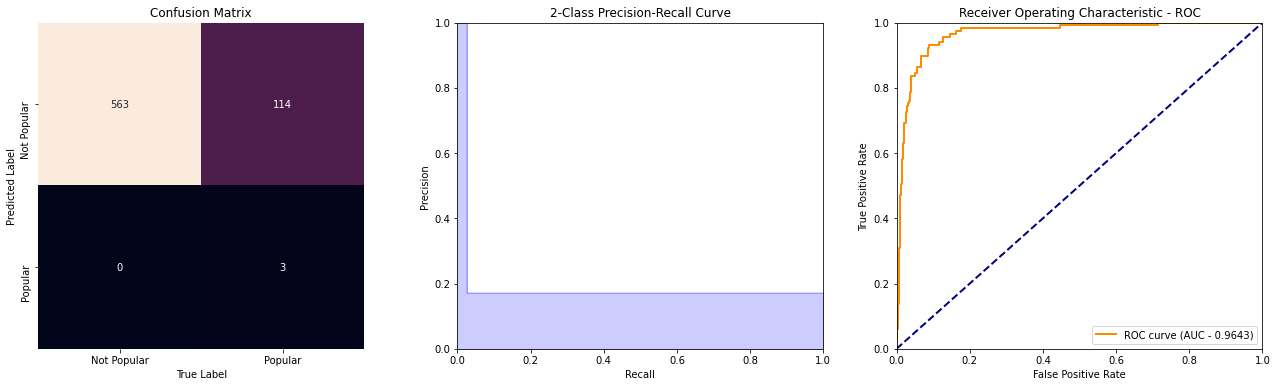

In [35]:
y_train_pred = logreg.predict(X_train)
y_train_prob = logreg.predict_proba(X_train)
summary_report(Y_train, y_train_pred, y_train_prob)

Accuracy : 0.8235 [TP / N] Proportion of Predicted Labels that match the True Labels.Best: 1, Worst: 0
Precision: 0.6667 [TP / (TP + FP)] Not to Label a negative sample as positive. Best:1, Worst: 0
Recall   : 0.0645 [TP / (TP + FN)] Find all the positive samples. Best:1, Worst: 0
ROC AUC  : 0.7814 Best:1, Worst: < 0.5
TP: True Positives, FP: False Positives,
TN: True Negatives, FN: False Negatives,
N: Number of Samples


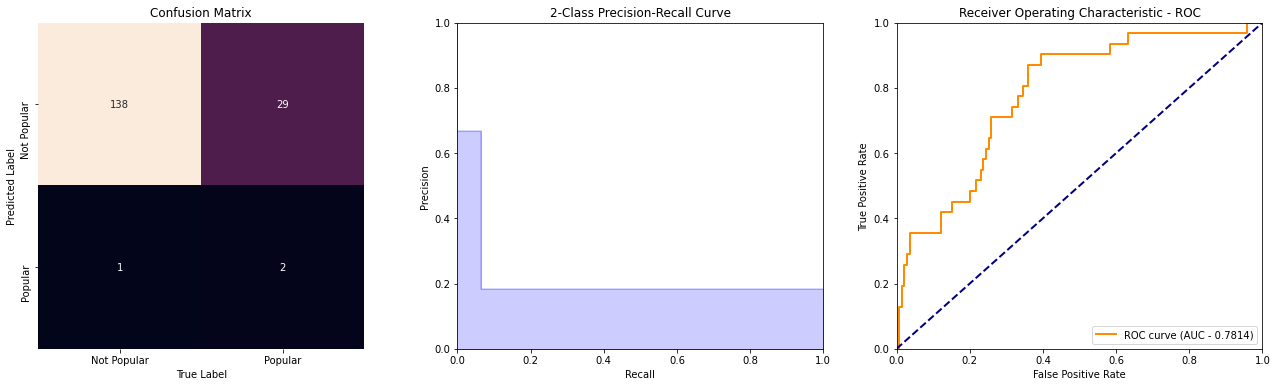

In [36]:
y_test_pred = logreg.predict(X_test)
y_test_prob = logreg.predict_proba(X_test)
summary_report(Y_test, y_test_pred, y_test_prob)

#### Part 5: K-Nearest Neighbours

In [37]:
# Train & Evaluate KNN

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train,Y_train)

# Cross Validation

scores = cross_val_score(knn, X_train, Y_train, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.81 accuracy with a standard deviation of 0.02


Accuracy : 0.8426 [TP / N] Proportion of Predicted Labels that match the True Labels.Best: 1, Worst: 0
Precision: 0.6667 [TP / (TP + FP)] Not to Label a negative sample as positive. Best:1, Worst: 0
Recall   : 0.1709 [TP / (TP + FN)] Find all the positive samples. Best:1, Worst: 0
ROC AUC  : 0.8690 Best:1, Worst: < 0.5
TP: True Positives, FP: False Positives,
TN: True Negatives, FN: False Negatives,
N: Number of Samples


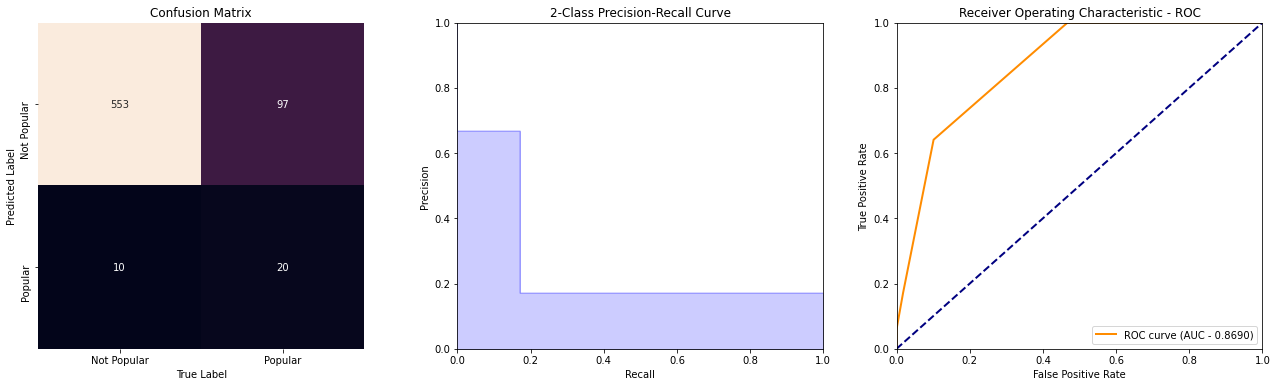

In [38]:
y_train_pred = knn.predict(X_train)
y_train_prob = knn.predict_proba(X_train)
summary_report(Y_train, y_train_pred, y_train_prob)

Accuracy : 0.8235 [TP / N] Proportion of Predicted Labels that match the True Labels.Best: 1, Worst: 0
Precision: 0.5714 [TP / (TP + FP)] Not to Label a negative sample as positive. Best:1, Worst: 0
Recall   : 0.1290 [TP / (TP + FN)] Find all the positive samples. Best:1, Worst: 0
ROC AUC  : 0.6011 Best:1, Worst: < 0.5
TP: True Positives, FP: False Positives,
TN: True Negatives, FN: False Negatives,
N: Number of Samples


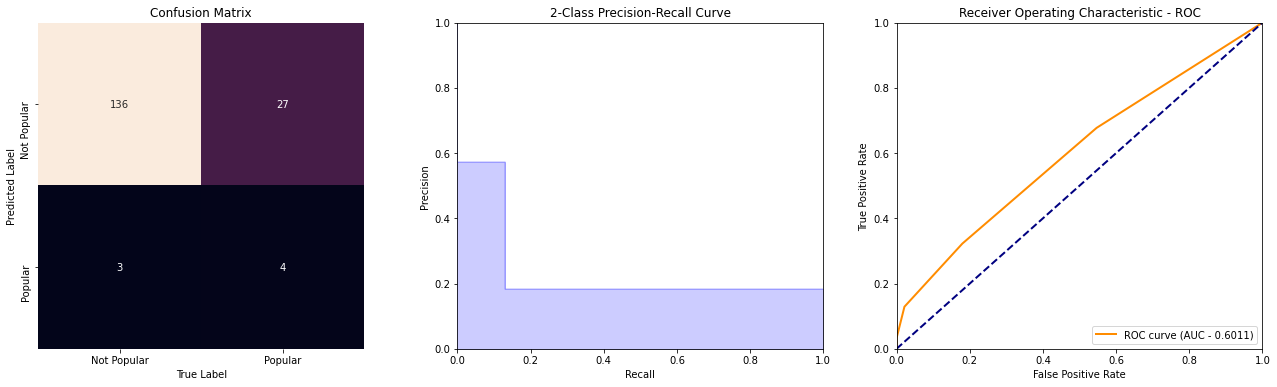

In [39]:
y_test_pred =knn.predict(X_test)
y_test_prob = knn.predict_proba(X_test)
summary_report(Y_test, y_test_pred, y_test_prob)

#### Part 6: Decision Trees

In [40]:
dtmodel = tree.DecisionTreeClassifier()
dtmodel.fit(X_train, Y_train)

scores = cross_val_score(dtmodel, X_train, Y_train, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.98 accuracy with a standard deviation of 0.01


Accuracy : 1.0000 [TP / N] Proportion of Predicted Labels that match the True Labels.Best: 1, Worst: 0
Precision: 1.0000 [TP / (TP + FP)] Not to Label a negative sample as positive. Best:1, Worst: 0
Recall   : 1.0000 [TP / (TP + FN)] Find all the positive samples. Best:1, Worst: 0
ROC AUC  : 1.0000 Best:1, Worst: < 0.5
TP: True Positives, FP: False Positives,
TN: True Negatives, FN: False Negatives,
N: Number of Samples


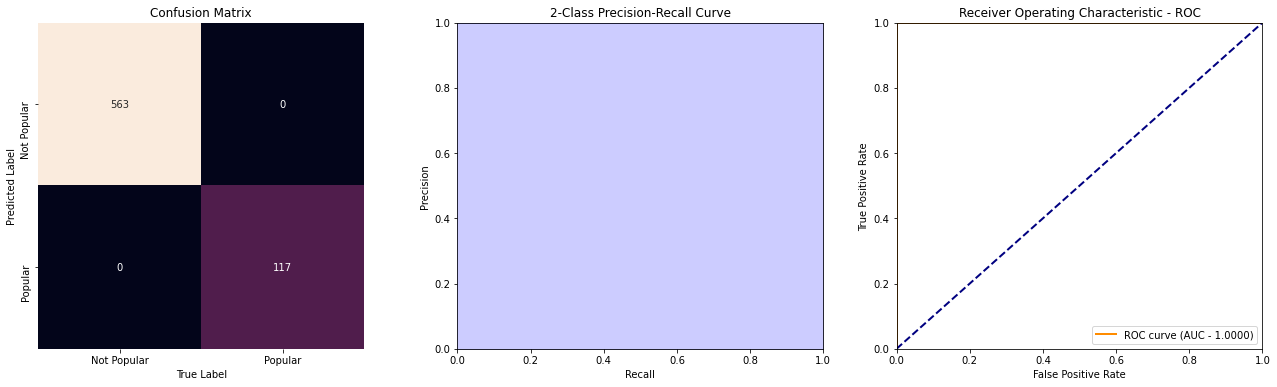

In [41]:
y_train_pred = dtmodel.predict(X_train)
y_train_prob = dtmodel.predict_proba(X_train)
summary_report(Y_train, y_train_pred, y_train_prob)

Accuracy : 0.9941 [TP / N] Proportion of Predicted Labels that match the True Labels.Best: 1, Worst: 0
Precision: 0.9688 [TP / (TP + FP)] Not to Label a negative sample as positive. Best:1, Worst: 0
Recall   : 1.0000 [TP / (TP + FN)] Find all the positive samples. Best:1, Worst: 0
ROC AUC  : 0.9964 Best:1, Worst: < 0.5
TP: True Positives, FP: False Positives,
TN: True Negatives, FN: False Negatives,
N: Number of Samples


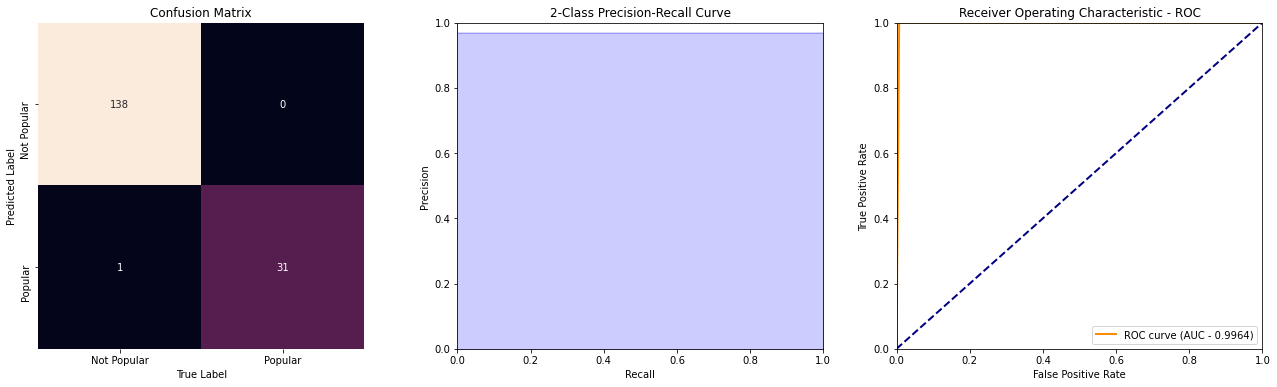

In [42]:
y_test_pred =dtmodel.predict(X_test)
y_test_prob = dtmodel.predict_proba(X_test)
summary_report(Y_test, y_test_pred, y_test_prob)